<a href="https://colab.research.google.com/github/sepehrkr/Deep-Learning-Course/blob/main/HW3/Deep_HW3_Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torchvision import models
import torch.nn as nn
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import Subset, DataLoader, Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt

## Part 1

In [ ]:
class Resnet(nn.Module):
    def __init__(self, class_num):
        super().__init__()
        self.resnet = models.resnet50(models.ResNet50_Weights.IMAGENET1K_V2)
        self.features = self.resnet.fc.in_features
        for param in self.resnet.parameters():
            param.requires_grad = False

        self.resnet.fc = nn.Linear(self.features,class_num)

    def forward(self,x:torch.Tensor):
        return self.resnet(x)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 32

my_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])
trainset = CIFAR10('.',train=True,download=True,transform=my_transform)
testset = CIFAR10('.',train=False,download=True,transform=my_transform)

classes = [trainset.class_to_idx['airplane'],trainset.class_to_idx['automobile']]
train_idxs = [idx for idx, label in enumerate(trainset.targets) if label in classes]
test_idxs = [idx for idx, label in enumerate(testset.targets) if label in classes]

trainset = Subset(trainset,train_idxs)
testset = Subset(testset,test_idxs)

trainLoader = DataLoader(trainset,batch_size,shuffle=True)
testLoader = DataLoader(testset,batch_size,shuffle=True)

num_images = len(trainset)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
model = Resnet(len(classes)).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

num_epochs = 10
losses = []
accuracies = []
len_trainLoader = len(trainLoader)
for epoch in range(num_epochs):
  model.train()
  current_loss = 0.0
  accuracy = 0.0
  tqdm_bar = tqdm(trainLoader, desc=f'Training Epoch {epoch} ', total=int(len_trainLoader))
  for i,(images, targets) in enumerate(tqdm_bar):
    images = images.to(device)
    targets = targets.to(device)
    labels = model(images)
    optimizer.zero_grad()
    loss = criterion(labels,targets)
    loss.backward()
    optimizer.step()
    current_loss += loss.item()
    _, prediction = torch.max(labels,dim=1)
    accuracy += (prediction==targets).sum()/batch_size # to prevent overflow.

  current_loss /= len_trainLoader
  losses.append(current_loss)
  accuracy = accuracy*batch_size/num_images
  accuracies.append(accuracy)
  print(f"Loss: {current_loss}, Accuracy: {accuracy}")
  torch.save(model.state_dict(), '/content/drive/MyDrive/Resnet50.pth')


Training Epoch 0 : 100%|██████████| 313/313 [01:56<00:00,  2.69it/s]


Loss: 0.22208196404404915, Accuracy: 0.9235000014305115


Training Epoch 1 : 100%|██████████| 313/313 [01:58<00:00,  2.64it/s]


Loss: 0.13369896621130906, Accuracy: 0.9526000022888184


Training Epoch 2 : 100%|██████████| 313/313 [01:57<00:00,  2.67it/s]


Loss: 0.11672910043416312, Accuracy: 0.9584999680519104


Training Epoch 3 : 100%|██████████| 313/313 [02:01<00:00,  2.59it/s]


Loss: 0.10405146788520078, Accuracy: 0.9602999687194824


Training Epoch 4 : 100%|██████████| 313/313 [01:53<00:00,  2.77it/s]


Loss: 0.09207170931830669, Accuracy: 0.9662999510765076


Training Epoch 5 : 100%|██████████| 313/313 [01:57<00:00,  2.66it/s]


Loss: 0.09387696588846346, Accuracy: 0.9645999670028687


Training Epoch 6 : 100%|██████████| 313/313 [02:03<00:00,  2.53it/s]


Loss: 0.0878745154314005, Accuracy: 0.967199981212616


Training Epoch 7 : 100%|██████████| 313/313 [02:02<00:00,  2.55it/s]


Loss: 0.08141107601336778, Accuracy: 0.9695000052452087


Training Epoch 8 : 100%|██████████| 313/313 [02:00<00:00,  2.59it/s]


Loss: 0.08184035264919647, Accuracy: 0.9687999486923218


Training Epoch 9 : 100%|██████████| 313/313 [01:52<00:00,  2.79it/s]


Loss: 0.07921757794523868, Accuracy: 0.9696999788284302


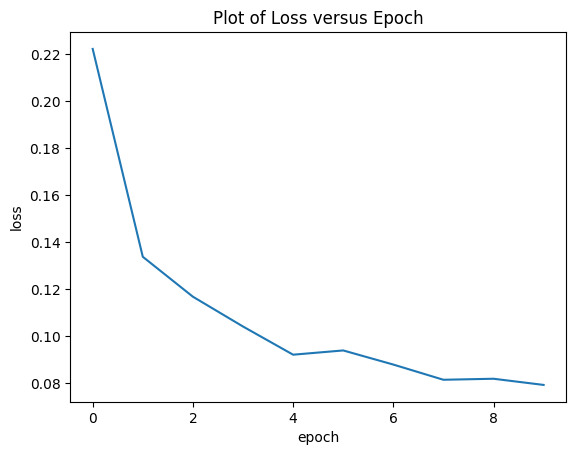

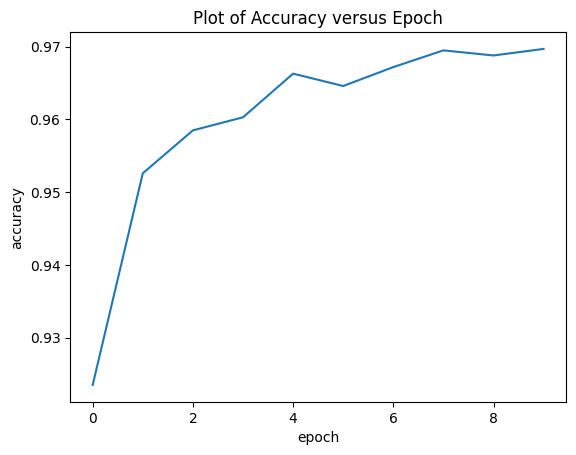

In [ ]:
plt.figure()
plt.plot(range(num_epochs),losses)
plt.title("Plot of Loss versus Epoch")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

accuracies = [accuracy.cpu() for accuracy in accuracies]
plt.figure()
plt.plot(range(num_epochs),accuracies)
plt.title("Plot of Accuracy versus Epoch")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()


In [ ]:
model.eval()
accuracy = 0.0
with torch.no_grad():
  for i,(images, targets) in enumerate(testLoader):
    images = images.to(device)
    targets = targets.to(device)
    labels = model(images)
    _, prediction = torch.max(labels,dim=1)
    accuracy += (prediction==targets).sum()

accuracy /= len(testset)
print(f"Accuracy of test set: {accuracy}")


Accuracy of test set: 0.968000054359436


## Part 2

In [ ]:
class MyDataset(Dataset):
    def __init__(self, dataset):
        super().__init__()
        self.classes = [0,1]
        self.idxs = [idx for idx, label in enumerate(dataset.targets) if label in self.classes]
        self.dataset = dataset
        self.transform = dataset.transform
        self.new_idxs = self.balance()

    def balance(self):
        classes = [0,1]
        i2class = {0:[],1:[]}
        for idx in self.idxs:
            label = self.dataset.targets[idx]
            if label == 0:
                i2class[0].append(idx)
            else:
                i2class[1].append(idx)

        len0 = len(i2class[0]) // 16
        len1 = len(i2class[1]) // 16
        leni = min(len0,len1)
        class0 = torch.tensor(i2class[0])
        class1 = torch.tensor(i2class[1])
        class0 = class0[torch.randperm(len(class0))]
        class1 = class1[torch.randperm(len(class1))]
        new_idxs = torch.cat([class0[:leni*16].reshape(-1,16),class1[:leni*16].reshape(-1,16)],dim=1)
        permutations = []
        for _ in range(leni):
          permutations.append(torch.randperm(32))
        permutations = torch.stack(permutations,dim=0)
        new_idxs = new_idxs[torch.arange(leni)[:,None],permutations].flatten()
        res = torch.cat([class0[leni*16:],class1[leni*16:]])
        res = res[torch.randperm(len(res))]
        new_idxs = torch.cat([new_idxs,res])
        return new_idxs

    def __getitem__(self, index):
        target = self.dataset.targets[self.new_idxs[index]]
        image = self.dataset.data[self.new_idxs[index]]
        image = self.transform(image)
        return (image, target)

    def __len__(self):
        return len(self.idxs)

In [ ]:
batch_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

my_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224),antialias=True),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

trainData = CIFAR10('.',train=True,download=True,transform=my_transform)
testData = CIFAR10('.',train=False,download=True,transform=my_transform)

trainset = MyDataset(trainData)
testset = MyDataset(testData)

trainLoader = DataLoader(trainset,batch_size)
testLoader = DataLoader(testset,batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
class tripletLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def create_mask(self,targets):
        B = len(targets)
        # i != j
        mask11 = torch.logical_not(torch.eye(B,device=torch.device('cuda')))

        # l(i) = l(j)
        mask12 = targets[:,None] == targets[None,:]

        # l(i) = l(j) and i != j
        mask1 = mask11 * mask12
        i1, j = torch.where(mask1==True)

        # l(k) != l(i)=l(j)
        mask2 = targets[:,None] != targets[None,:]

        mask = mask1[:,:,None] * mask2[:,None,:]
        return mask

    def loss_matrix(self,features):
        m = features @ features.t()
        d = m.diag()
        distance_matrix = d[:,None] + d[None,:] - 2*m
        L = distance_matrix[:,:,None] - distance_matrix[:,None,:]
        return L

    def forward(self,features, targets):
        mask = self.create_mask(targets)
        loss = self.loss_matrix(features)
        loss = loss[mask]
        loss = torch.maximum(loss,torch.zeros_like(loss)).mean()
        return loss


class Resnet(nn.Module):
    def __init__(self, class_num, mode='feature'):
        super().__init__()
        assert mode in {'feature','class','both'}
        self.mode = mode
        self.resnet = models.resnet50(models.ResNet50_Weights.IMAGENET1K_V2)
        self.features = self.resnet.fc.in_features
        self.resnet = torch.nn.Sequential(*list(self.resnet.children())[:-1])

        if mode == 'class':
          self.resnet.load_state_dict(torch.load('/content/drive/MyDrive/resnet_params.pth'))
          for param in self.resnet.parameters():
              param.requires_grad = False
          self.lin = nn.Linear(self.features,class_num)

          if mode == 'both':
            self.lin = nn.Linear(self.features,class_num)

    def forward(self,x:torch.Tensor):
        x = self.resnet(x).squeeze()
        if self.mode == 'class' or self.mode == 'both':
          x = self.lin(x)
        return x

In [ ]:
model = Resnet(class_num=2, mode='feature').to(device)
criterion = tripletLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

num_epochs = 10
losses = []
len_trainLoader = len(trainLoader)
for epoch in range(num_epochs):
  model.train()
  current_loss = 0.0
  tqdm_bar = tqdm(trainLoader, desc=f'Training Epoch {epoch} ', total=int(len_trainLoader))
  for i,(images, targets) in enumerate(tqdm_bar):
    images = images.to(device)
    targets = targets.to(device)
    features = model(images)
    optimizer.zero_grad()
    loss = criterion(features,targets)
    loss.backward()
    optimizer.step()
    current_loss += loss.item()

  current_loss /= len_trainLoader
  losses.append(current_loss)
  print(f"Loss: {current_loss}")
  torch.save(model.resnet.state_dict(), '/content/drive/MyDrive/resnet_params.pth')


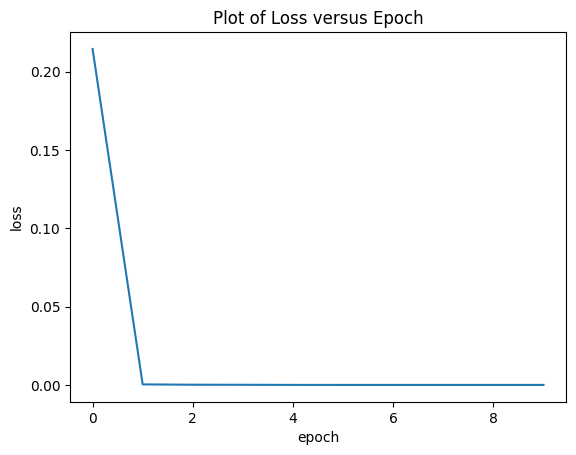

In [ ]:
plt.figure()
plt.plot(range(num_epochs),losses)
plt.title("Plot of Loss versus Epoch")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()


In [ ]:
model = Resnet(class_num=2, mode='class').to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

num_epochs = 10
losses = []
accuracies = []
len_trainLoader = len(trainLoader)
num_images = len(trainset)
for epoch in range(num_epochs):
  model.train()
  current_loss = 0.0
  accuracy = 0.0
  tqdm_bar = tqdm(trainLoader, desc=f'Training Epoch {epoch} ', total=int(len_trainLoader))
  for i,(images, targets) in enumerate(tqdm_bar):
    images = images.to(device)
    targets = targets.to(device)
    labels = model(images)
    optimizer.zero_grad()
    loss = criterion(labels,targets)
    loss.backward()
    optimizer.step()
    current_loss += loss.item()
    _, prediction = torch.max(labels,dim=1)
    accuracy += (prediction==targets).sum()/batch_size # to prevent overflow.

  current_loss /= len_trainLoader
  losses.append(current_loss)
  accuracy = accuracy*batch_size/num_images
  accuracies.append(accuracy)
  print(f"Loss: {current_loss}, Accuracy: {accuracy}")
  torch.save(model.state_dict(), '/content/drive/MyDrive/Resnet50_tripleLoss.pth')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Training Epoch 0 : 100%|██████████| 313/313 [01:30<00:00,  3.44it/s]


Loss: 0.69310873804001, Accuracy: 0.5073999762535095


Training Epoch 1 : 100%|██████████| 313/313 [01:30<00:00,  3.46it/s]


Loss: 0.6930492392744119, Accuracy: 0.5159000158309937


Training Epoch 2 : 100%|██████████| 313/313 [01:33<00:00,  3.37it/s]


Loss: 0.692983189901224, Accuracy: 0.5162999629974365


Training Epoch 3 : 100%|██████████| 313/313 [01:39<00:00,  3.14it/s]


Loss: 0.692916001184299, Accuracy: 0.5166999697685242


Training Epoch 4 : 100%|██████████| 313/313 [01:27<00:00,  3.58it/s]


Loss: 0.6928492830203364, Accuracy: 0.5167999863624573


Training Epoch 5 : 100%|██████████| 313/313 [01:39<00:00,  3.14it/s]


Loss: 0.6927835895611455, Accuracy: 0.5169999599456787


Training Epoch 6 : 100%|██████████| 313/313 [01:32<00:00,  3.38it/s]


Loss: 0.6927191571305735, Accuracy: 0.5171999931335449


Training Epoch 7 : 100%|██████████| 313/313 [01:26<00:00,  3.63it/s]


Loss: 0.6926560639954222, Accuracy: 0.5170999765396118


Training Epoch 8 : 100%|██████████| 313/313 [01:39<00:00,  3.14it/s]


Loss: 0.692594345194844, Accuracy: 0.5173999667167664


Training Epoch 9 : 100%|██████████| 313/313 [01:37<00:00,  3.20it/s]


Loss: 0.692533977115497, Accuracy: 0.5175999999046326


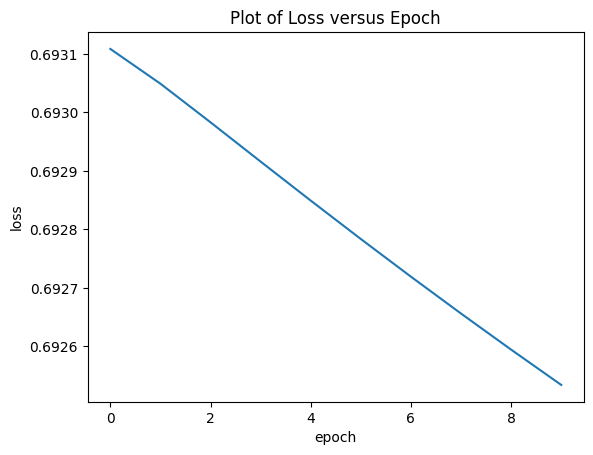

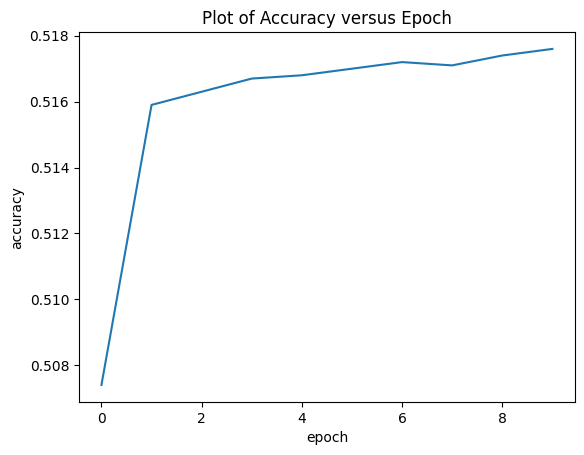

In [ ]:
plt.figure()
plt.plot(range(num_epochs),losses)
plt.title("Plot of Loss versus Epoch")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

accuracies = [accuracy.cpu() for accuracy in accuracies]
plt.figure()
plt.plot(range(num_epochs),accuracies)
plt.title("Plot of Accuracy versus Epoch")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()


In [ ]:
model.eval()
accuracy = 0.0
with torch.no_grad():
  for i,(images, targets) in enumerate(testLoader):
    images = images.to(device)
    targets = targets.to(device)
    labels = model(images)
    _, prediction = torch.max(labels,dim=1)
    accuracy += (prediction==targets).sum()

accuracy /= len(testset)
print(f"Accuracy of test set: {accuracy}")


Accuracy of test set: 0.5110000371932983


# Part 3

In [ ]:
class tripletLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def create_mask(self,targets):
        B = len(targets)
        # i != j
        mask11 = torch.logical_not(torch.eye(B,device=torch.device('cuda')))

        # l(i) = l(j)
        mask12 = targets[:,None] == targets[None,:]

        # l(i) = l(j) and i != j
        mask1 = mask11 * mask12
        i1, j = torch.where(mask1==True)

        # l(k) != l(i)=l(j)
        mask2 = targets[:,None] != targets[None,:]

        mask = mask1[:,:,None] * mask2[:,None,:]
        return mask

    def loss_matrix(self,features):
        m = features @ features.t()
        d = m.diag()
        distance_matrix = d[:,None] + d[None,:] - 2*m
        L = distance_matrix[:,:,None] - distance_matrix[:,None,:]
        return L

    def forward(self,features, targets):
        mask = self.create_mask(targets)
        loss = self.loss_matrix(features)
        loss = loss[mask]
        loss = torch.maximum(loss,torch.zeros_like(loss)).mean()
        return loss


class Resnet_total(nn.Module):
    def __init__(self, class_num):
        super().__init__()
        self.resnet = models.resnet50(models.ResNet50_Weights.IMAGENET1K_V2)
        self.features = self.resnet.fc.in_features
        self.resnet = torch.nn.Sequential(*list(self.resnet.children())[:-1])
        self.lin = nn.Linear(self.features,class_num)

    def forward(self,x:torch.Tensor):
        x = self.resnet(x).squeeze()
        features = x
        x = self.lin(x)
        return x, features

In [ ]:
model = Resnet_total(class_num=2).to(device)
criterion_triplet = tripletLoss().to(device)
criterion_entropy = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

num_epochs = 10
losses = []
accuracies = []
len_trainLoader = len(trainLoader)
num_images = len(trainset)
for epoch in range(num_epochs):
  model.train()
  current_loss = 0.0
  accuracy = 0.0
  tqdm_bar = tqdm(trainLoader, desc=f'Training Epoch {epoch} ', total=int(len_trainLoader))
  for i,(images, targets) in enumerate(tqdm_bar):
    images = images.to(device)
    targets = targets.to(device)
    labels, features = model(images)
    optimizer.zero_grad()
    loss_entropy = criterion_entropy(labels,targets)
    loss_triplet = criterion_triplet(features,targets)
    loss = loss_entropy + loss_triplet
    loss.backward()
    optimizer.step()
    current_loss += loss.item()
    _, prediction = torch.max(labels,dim=1)
    accuracy += (prediction==targets).sum()/batch_size # to prevent overflow.

  current_loss /= len_trainLoader
  losses.append(current_loss)
  accuracy = accuracy*batch_size/num_images
  accuracies.append(accuracy)
  print(f"Loss: {current_loss}, Accuracy: {accuracy}")
  torch.save(model.state_dict(), '/content/drive/MyDrive/Resnet50_total.pth')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Training Epoch 0 : 100%|██████████| 313/313 [03:11<00:00,  1.63it/s]


Loss: 0.4147936611320264, Accuracy: 0.9659000039100647


Training Epoch 1 : 100%|██████████| 313/313 [03:07<00:00,  1.67it/s]


Loss: 0.06699552719098942, Accuracy: 0.9909999966621399


Training Epoch 2 : 100%|██████████| 313/313 [03:07<00:00,  1.67it/s]


Loss: 0.04620502473482975, Accuracy: 0.9932999610900879


Training Epoch 3 : 100%|██████████| 313/313 [03:08<00:00,  1.66it/s]


Loss: 0.0319748813554774, Accuracy: 0.995199978351593


Training Epoch 4 : 100%|██████████| 313/313 [03:08<00:00,  1.66it/s]


Loss: 0.035967973206611055, Accuracy: 0.9934999942779541


Training Epoch 5 : 100%|██████████| 313/313 [03:09<00:00,  1.65it/s]


Loss: 0.026051542571706388, Accuracy: 0.9953999519348145


Training Epoch 6 : 100%|██████████| 313/313 [03:07<00:00,  1.67it/s]


Loss: 0.027233888749304724, Accuracy: 0.9949999451637268


Training Epoch 7 : 100%|██████████| 313/313 [03:08<00:00,  1.66it/s]


Loss: 0.026768373145102397, Accuracy: 0.9946999549865723


Training Epoch 8 : 100%|██████████| 313/313 [03:16<00:00,  1.59it/s]


Loss: 0.03046565456501842, Accuracy: 0.9939000010490417


Training Epoch 9 : 100%|██████████| 313/313 [03:14<00:00,  1.61it/s]


Loss: 0.02606685038758929, Accuracy: 0.9949999451637268


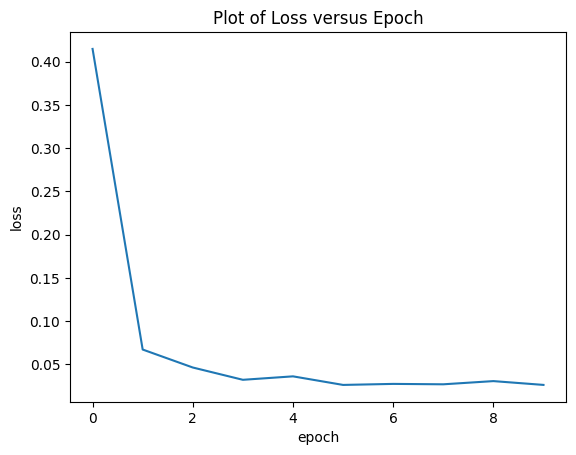

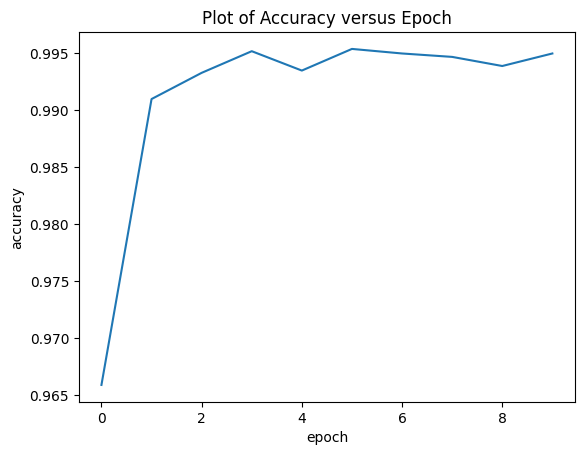

In [ ]:
plt.figure()
plt.plot(range(num_epochs),losses)
plt.title("Plot of Loss versus Epoch")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

accuracies = [accuracy.cpu() for accuracy in accuracies]
plt.figure()
plt.plot(range(num_epochs),accuracies)
plt.title("Plot of Accuracy versus Epoch")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()


In [ ]:
model.eval()
accuracy = 0.0
with torch.no_grad():
  for i,(images, targets) in enumerate(testLoader):
    images = images.to(device)
    targets = targets.to(device)
    labels,_ = model(images)
    _, prediction = torch.max(labels,dim=1)
    accuracy += (prediction==targets).sum()

accuracy /= len(testset)
print(f"Accuracy of test set: {accuracy}")


Accuracy of test set: 0.9890000224113464
